In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import csv

In [2]:
data_root_dir = './data/torobo/815_trajs_static'
obs_array = np.load(data_root_dir + '/obs.npy', allow_pickle=True, encoding='latin1')
# obs_array = np.squeeze(obs_array, axis=-1)
obs_array.shape

(80, 50, 5)

In [3]:
obs_array[0][1]

array([1,
       array([ 1.39793938,  0.96211687,  1.16403943,  1.5278029 , -0.42459696,
               1.00631262,  0.60650599])                                      ,
       list([0.49106420416271046, -0.19013584300673003, 0.865]),
       list([0.30945715515371675, -0.27936021453376786, 0.865]),
       list([0.3445427066068857, -0.029864659804874516, 0.865])],
      dtype=object)

In [4]:
episodes_list = []
for i in range(obs_array.shape[0]):
    timestep_list = []
    for j in range(obs_array.shape[1]):
        data_timestep = obs_array[i, j]
        timestep = data_timestep[0]
        joint_values = data_timestep[1]
        target_pos = data_timestep[2]
        tmp_list = [timestep]
        for k in range(joint_values.size):
            tmp_list.append(joint_values[k])
        for k in range(len(target_pos)):
            tmp_list.append(target_pos[k])
        timestep_list.append(tmp_list)
        
    episodes_list.append(timestep_list)

AttributeError: 'list' object has no attribute 'size'

In [ ]:
torobo_data = np.array(episodes_list)
print(torobo_data.shape)

(144, 50, 11)


In [ ]:
with open(data_root_dir + '/trajectories.npy', 'wb') as f:
    np.save(f, torobo_data)

In [ ]:
with open(data_root_dir + '/trajectories.npy', 'rb') as f:
    torobo_data = np.load(f)
print(torobo_data.shape)
print(torobo_data.dtype)

(144, 50, 11)
float64


In [ ]:
steps = torobo_data[:, :, 0]
joint_values = torobo_data[:, :, 1:8]
target_points = torobo_data[:, :, 8:]
print(steps.shape)
print(joint_values.shape)
print(target_points.shape)

(144, 50)
(144, 50, 7)
(144, 50, 3)


In [ ]:
def calculate_vel_act(array, start_idx, end_idx):
    vel_episodes, act_episodes = [], []
    for i in range(array.shape[0]):
        vel_steps, act_steps = [], []
        for j in range(array.shape[1]):
            cur_vals = array[i][j][start_idx:end_idx]
            if j != 0:
                prev_vals = array[i][j-1][start_idx:end_idx]
            # else: prev_vals = np.zeros(end_idx-start_idx)
            else: 
                prev_vals = cur_vals

            if j != array.shape[1]-1:
                next_vals = array[i][j+1][start_idx:end_idx]
                act = next_vals - cur_vals

            vel_steps.append(cur_vals - prev_vals)
            act_steps.append(act)
        vel_episodes.append(vel_steps)
        act_episodes.append(act_steps)

    return np.array(vel_episodes), np.array(act_episodes)

In [ ]:
velocs, acts = calculate_vel_act(torobo_data, 1, 9)
print(velocs.shape)
# torqs = calculate_torq_vel(velocs, 0, 7)
print(acts.shape)

(144, 50, 7)
(144, 50, 7)


In [ ]:
states = np.concatenate((joint_values, velocs), axis=2)
print(states.shape)

(144, 50, 14)


In [ ]:
# Calculate mean and standard deviation along the last dimension
mean = np.mean(states, axis=(0, 1))#, keepdims=True)
std = np.std(states, axis=(0, 1))#, keepdims=True)

# mean_10K = np.array([-0.00188743, 0.00013914, -0.00315345, 0.01042289])
# std_10K = np.array([0.91649005, 1.31088051, 2.16946285, 3.51440869])
print("mean", mean)
print("std", std)

with open(data_root_dir + "/stats.csv", 'w') as f:
    writer = csv.writer(f)
    row = ["ds_name", "mean", "std"]
    writer.writerow(row)

    row = ["torobo", str(mean), str(std)]
    writer.writerow(row)

normalized_states = (states - mean) / std
print(normalized_states.shape)

mean [ 1.32992016e+00  1.16893094e+00  4.75061350e-01  9.34866042e-01
 -1.48564714e+00 -1.06043919e+00  1.07591402e+00 -4.30997512e-03
 -5.97830623e-06 -7.97757909e-04  3.14511202e-03 -1.27610726e-02
  2.15895055e-03  1.27564559e-02]
std [0.18929656 0.26122264 0.1385783  0.48794231 0.37383509 0.30146034
 0.37454724 0.01025512 0.0138198  0.00897769 0.00892031 0.02141356
 0.01329758 0.02272061]
(144, 50, 14)


In [ ]:
steps = steps[:, :, np.newaxis]
normalized_training_data = np.concatenate((steps, normalized_states), 
                                            axis=2)
normalized_training_data = np.concatenate((normalized_training_data, acts), #
                                            axis=2)
normalized_training_data = np.concatenate((normalized_training_data, target_points), 
                                            axis=2)                                            
print("normalized_training_data.shape:", normalized_training_data.shape)

# np.save(data_root_dir+"/trajectories.npy", trajectories)
np.save(data_root_dir+"/trajectories_normalized.npy", normalized_training_data)

normalized_training_data.shape: (144, 50, 25)


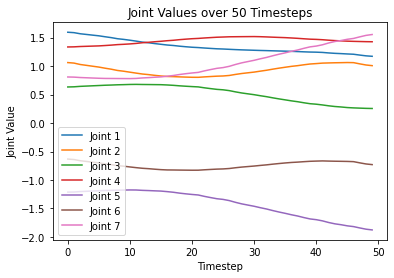

In [ ]:
plot_data = torobo_data[0, :, 1:8]

# Create a figure and axis
fig, ax = plt.subplots()

# Plot each column in the array
for i in range(plot_data.shape[1]):
    ax.plot(plot_data[:, i], label=f'Joint {i+1}')

# Add labels and title
ax.set_xlabel('Timestep')
ax.set_ylabel('Joint Value')
ax.set_title('Joint Values over 50 Timesteps')
ax.legend()

# Show the plot
plt.show()


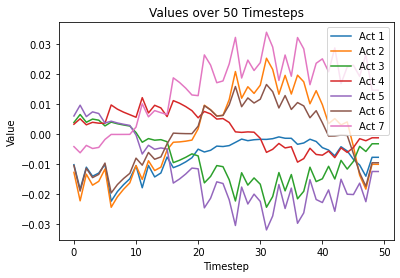

In [ ]:
episode_no = 2
joints_plot = normalized_training_data[episode_no, :, 1:8]
velocs_plot = normalized_training_data[episode_no, :, 8:15]
acts_plot = normalized_training_data[episode_no, :, 15:22]

# Create a figure and axis
fig, ax = plt.subplots()

# Plot each column in the array
#for i in range(joints_plot.shape[1]):
#    ax.plot(joints_plot[:, i], label=f'Joint {i+1}')
    #break
#for i in range(velocs_plot.shape[1]):
#    ax.plot(velocs_plot[:, i], label=f'Veloc {i+1}', linestyle='--')
    #break
for i in range(acts_plot.shape[1]):
    ax.plot(acts_plot[:, i], label=f'Act {i+1}', linestyle='-')
    #break

# Add labels and title
ax.set_xlabel('Timestep')
ax.set_ylabel('Value')
ax.set_title('Values over 50 Timesteps')
ax.legend()

# Show the plot
plt.show()


In [ ]:
torobo_data[30]

array([[ 6.        ,  1.09385459,  0.62115398,  0.79523067,  1.31854902,
        -1.10757925, -1.2341541 ,  0.70239451,  0.6       ,  0.09318517,
         1.29823619],
       [ 7.        ,  1.08828056,  0.61966999,  0.79320865,  1.31860083,
        -1.11732731, -1.2380174 ,  0.71331087,  0.6       ,  0.09318517,
         1.29823619],
       [ 8.        ,  1.07469816,  0.61716208,  0.78760384,  1.31772778,
        -1.14314161, -1.2474279 ,  0.74215506,  0.6       ,  0.09318517,
         1.29823619],
       [ 9.        ,  1.0674411 ,  0.61579782,  0.78462399,  1.31728325,
        -1.15688895, -1.252456  ,  0.75751724,  0.6       ,  0.09318517,
         1.29823619],
       [10.        ,  1.05757982,  0.61394805,  0.78057228,  1.3166756 ,
        -1.17557702, -1.25928847,  0.7784003 ,  0.6       ,  0.09318517,
         1.29823619],
       [11.        ,  1.04884178,  0.61230898,  0.77698196,  1.31613722,
        -1.1921364 , -1.26534266,  0.7969046 ,  0.6       ,  0.09318517,
         1.298

Target

In [ ]:
target_points.shape

(144, 50, 3)

Text(0.5, 0, 'Z Label')

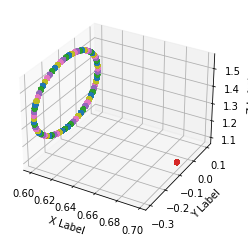

In [ ]:
# Create a figure
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the data points
for i in range(target_points.shape[0]):
    x = target_points[i, :, 0]
    y = target_points[i, :, 1]
    z = target_points[i, :, 2]
    ax.scatter(x, y, z)

# Set labels
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')